In [51]:
import numpy as np
from tqdm import *
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
from torch.utils.data import Dataset
from math import exp, log

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [53]:
# Here we define the general structure RBM

class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hid=500,
                 k=5):
        super(RBM, self).__init__()
        
        # parameters of the RBM
        self.W = nn.Parameter(torch.randn(n_hid,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.k = k
    
    # function which allows to sample from a general probability distribution
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    # sample a visible given an hidden unit
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    # sample an hidden given a visible unit
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
    
    # given a visible, get a new one performing k Gibbs sampling steps
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    # compute the gradient of the log-likelihood
    def backward(self, target, vk):
        # p(H_i | v) where v is the input data
        probability = torch.sigmoid(F.linear(target, self.W, self.h_bias))

        # p(H_i | v) where v is the negative visible layer
        h_prob_negative = torch.sigmoid(F.linear(vk, self.W, self.h_bias))
        # Update the W
        training_set_avg = probability.t().mm(target)
        # The minus sign comes from the implementation of the SGD in pytorch 
        # see http://www.cs.toronto.edu/~hinton/absps/momentum.pdf
        # the learning rate has a negative sign in front
        self.W.grad = -(training_set_avg - h_prob_negative.t().mm(vk)) / probability.size(0)

        # Update the v_bias
        self.v_bias.grad = -(target - vk).mean(0)

        # Update the h_bias
        self.h_bias.grad = -(probability - h_prob_negative).mean(0)

In [54]:
# General function to read the training set

class CSV_Ising_dataset(Dataset):
    """ Defines a CSV reader """
    def __init__(self, csv_file, size=32, transform=None, skiprows=1):
        self.csv_file = csv_file
        self.size = size
        csvdata = np.loadtxt(csv_file, delimiter=",", skiprows=skiprows, dtype="float32")
        self.imgs = torch.from_numpy(csvdata.reshape(-1, size))
        self.datasize, sizesq = self.imgs.shape
        self.transform = transform
        print("# Loaded training set of %d states" % self.datasize)

    def __getitem__(self, index):
        return self.imgs[index], index

    def __len__(self):
        return len(self.imgs)

In [55]:
# read the training set

train_loader = torch.utils.data.DataLoader(CSV_Ising_dataset("./training.data", size=6), shuffle=True,
                                               batch_size=200, drop_last=True)

# Loaded training set of 10000 states


In [56]:
# define an RBM and initialize stocastic gradient descent, setting the learning rate to 0.1

rbm = RBM(k=5, n_vis=6, n_hid=6)
train_op = optim.SGD(rbm.parameters(),0.1)

In [57]:
# perform the training for 100 epochs

pbar = tqdm(range(0, 100))
torch.save(rbm.state_dict(), "./not_trained_rbm.pytorch")

for epoch in pbar:
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data_input = Variable(data.view(-1,6))
        visible, new_visible = rbm(data_input)
        
        # Update gradients
        train_op.zero_grad()
        # manually update the gradients, do not use autograd
        rbm.backward(data_input, new_visible)
        train_op.step()

torch.save(rbm.state_dict(), "./trained_rbm.pytorch")

100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


In [58]:
# In the following we reconstruct the probability distribution learnt by the RBM and we compare
# it with the probability distribution from which the training set has been sampled.

In [59]:
# load the trained and the not-trained RBMs

trained_rbm = RBM(n_vis=6, n_hid=6)
not_trained_rbm = RBM(n_vis=6, n_hid=6)

trained_rbm.load_state_dict(torch.load("./trained_rbm.pytorch"))
not_trained_rbm.load_state_dict(torch.load("./not_trained_rbm.pytorch"))

In [60]:
# Define the tru underlying distribution, from which the training set has been sampled

# Ising energy
def Ising(s):
    H = (s[0]*s[1] + s[1]*s[2] + s[2]*s[3] + s[3]*s[4] + s[4]*s[5])
    return H

# Exact Ising distribution
def p(s):
    Z = 2*pow(exp(1)+exp(-1),5) # exact value of the partitional function for the 1-dim case
    prob = exp(Ising(s))/Z
    return(prob)


In [61]:
# Built the 64 possible state for a Ising chain of 6 states

sigma1rb = [1,0]
sigma2rb = [1,0]
sigma3rb = [1,0]
sigma4rb = [1,0]
sigma5rb = [1,0]
sigma6rb = [1,0]

N = 0
sigmaRb = [0 for i in range(64)]

for i1 in range(2):
    for i2 in range(2):
        for i3 in range(2):
            for i4 in range(2):
                for i5 in range(2):
                    for i6 in range(2):
                        sigmaRb[N] = [sigma1rb[i1],sigma2rb[i2],sigma3rb[i3],sigma4rb[i4],sigma5rb[i5],sigma6rb[i6]]
                        sigmaRb[N] = torch.from_numpy(np.asarray(sigmaRb[N])).float()
                        N = N + 1

In [62]:
# Define some function to read the parametrs from the RBM and reconstruct its probability distribution

# RBM free energy
def free_energy(v, model):
    v_bias = model.v_bias.data
    h_bias = model.h_bias.data
    W = model.W.data
    vbias_term = v.dot(v_bias)  # = v*v_bias
    wx_b = F.linear(v, W, h_bias)  # = vW^T + h_bias
    hidden_term = wx_b.exp().add(1).log().sum()
    return (hidden_term + vbias_term)  

# Exact RBM partitional function
Zrbm = 0
for i in range(64):
    Zrbm = Zrbm + exp(free_energy(sigmaRb[i], rbm))


# Probability distribution described by RBM
def P_rbm(s,model):
    prob = exp(free_energy(s,model))/Zrbm
    return(prob)


In [63]:
# Build distributions
x = [0 for i in range(64)]
y = [0 for i in range(64)]
z = [0 for i in range(64)]
Y = [0 for i in range(64)]

for i in range(64):
    x[i] = i
    y[i] = P_rbm(sigmaRb[i], trained_rbm)
    z[i] = P_rbm(sigmaRb[i], not_trained_rbm)
    Y[i] = p(sigmaRb[i]*2-1)

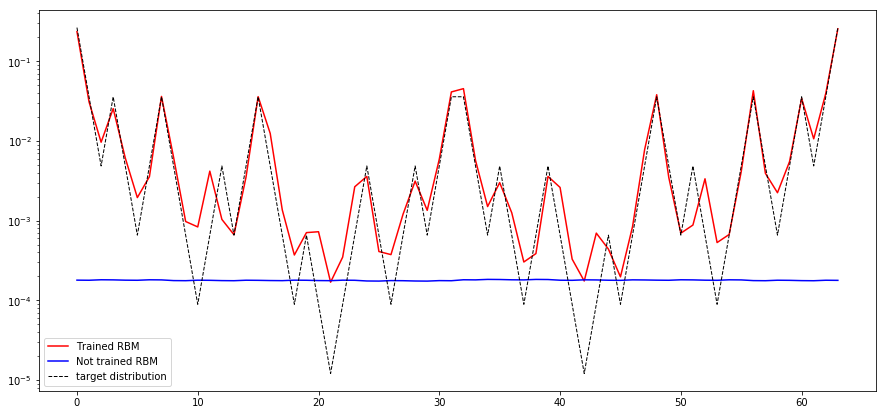

In [64]:
plt.figure(figsize=(15, 7))
plt.semilogy(x,y, c = "red", label = "Trained RBM")
plt.semilogy(x,z, c = "blue", label = "Not trained RBM")
plt.semilogy(x,Y, "--" , color="black", linewidth=1, label = "target distribution")
plt.legend()
plt.show()